In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime

In [2]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df = pd.read_csv('/content/ALI Historical Data_Cleaned.csv', usecols=['Date', 'Price'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index()
df = df.asfreq('B')

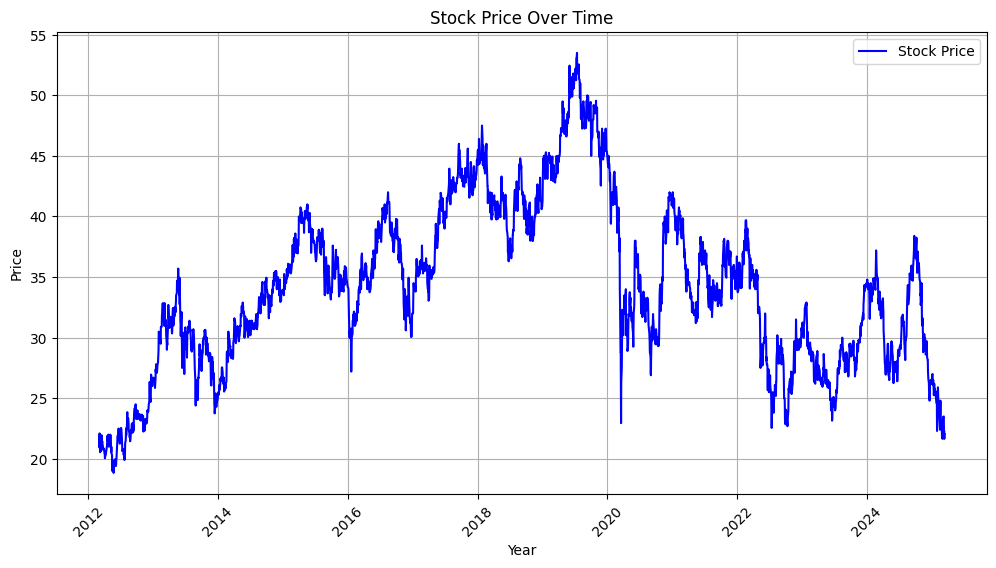

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label="Stock Price", color='blue')
plt.xlabel("Year")
plt.ylabel("Price")
plt.title("Stock Price Over Time")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend()
plt.grid()
plt.show()

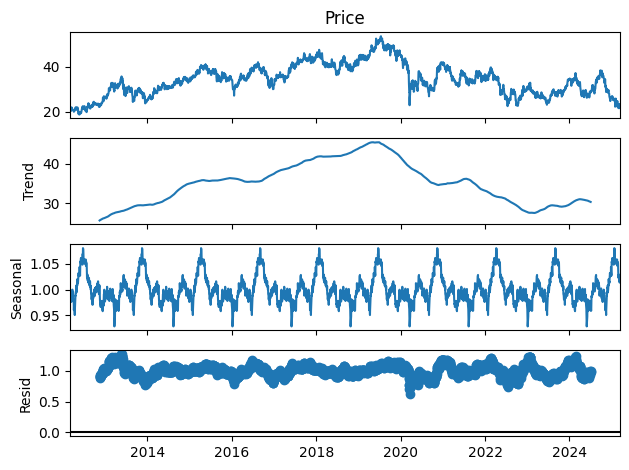

In [4]:
results = seasonal_decompose(df['Price'], model='multiplicative', period=365)
results.plot()
plt.show()

In [5]:
train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))
train = df.iloc[:train_size]
val = df.iloc[train_size:train_size+val_size]
test = df.iloc[train_size+val_size:]

In [6]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_val = scaler.transform(val)
scaled_test = scaler.transform(test)

In [7]:
scaled_train = np.array(scaled_train).reshape(-1, 1)
scaled_val = np.array(scaled_val).reshape(-1, 1)
scaled_test = np.array(scaled_test).reshape(-1, 1)

In [8]:
n_input = 90
n_features = 1
train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
val_generator = TimeseriesGenerator(scaled_val, scaled_val, length=n_input, batch_size=1)

In [9]:
model = Sequential([
    LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_input, n_features)),
    Dropout(0.2),
    LSTM(50, activation='tanh'),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 90, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 90, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,301 (282.43 KB)

 Trainable params: 72,301 (282.43 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
checkpoint = ModelCheckpoint("ALI_model.h5", save_best_only=True, monitor='val_loss', mode='min')

In [11]:
history = model.fit(train_generator, epochs=30, validation_data=val_generator, callbacks=[early_stopping, checkpoint])

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2630/2630 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0091

2630/2630 ━━━━━━━━━━━━━━━━━━━━ 253s 94ms/step - loss: 0.0091 - val_loss: 7.0295e-04
Epoch 2/30
2630/2630 ━━━━━━━━━━━━━━━━━━━━ 244s 93ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 3/30
2630/2630 ━━━━━━━━━━━━━━━━━━━━ 246s 94ms/step - loss: 0.0016 - val_loss: 7.0561e-04
Epoch 4/30
2630/2630 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0013

2630/2630 ━━━━━━━━━━━━━━━━━━━━ 240s 91ms/step - loss: 0.0013 - val_loss: 2.3986e-04
Epoch 5/30
2630/2630 ━━━━━━━━━━━━━━━━━━━━ 241s 91ms/step - loss: 0.0012 - val_loss: 2.8556e-04
Epoch 6/30
2630/2630 ━━━━━━━━━━━━━━━━━━━━ 239s 91ms/step - loss: 0.0013 - val_loss: 2.4910e-04
Epoch 7/30
2630/2630 ━━━━━━━━━━━━━━━━━━━━ 237s 90ms/step - loss: 0.0012 - val_loss: 2.7169e-04
Epoch 8/30
2630/2630 ━━━━━━━━━━━━━━━━━━━━ 236s 90ms/step - loss: 0.0012 - val_loss: 8.6376e-04
Epoch 9/30
2630/2630 ━━━━━━━━━━━━━━━━━━━━ 243s 93ms/step - loss: 0.0010 - val_loss: 3.0757e-04


In [12]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
model.save("ALI_Model.h5")

In [13]:
full_scaled = scaler.transform(df)
full_scaled = np.array(full_scaled).reshape(-1, 1)
first_eval_batch = full_scaled[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

future_steps = 7
future_predictions = []

for i in range(future_steps):
    current_pred = model.predict(current_batch)[0]
    future_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


In [14]:
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

In [15]:
actual_recent = df.tail(23)

In [16]:
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=future_steps, freq='B')

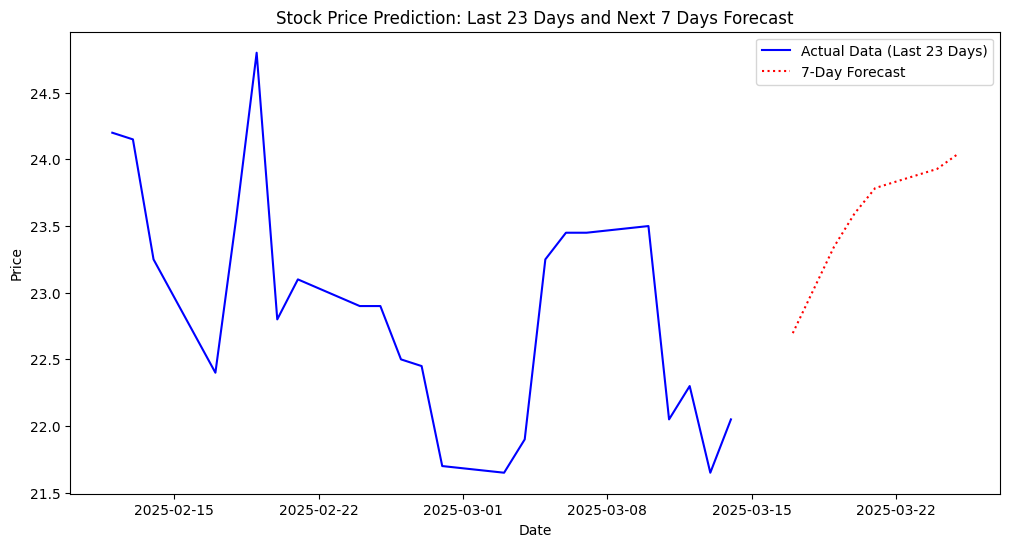

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(actual_recent.index, actual_recent['Price'], label='Actual Data (Last 23 Days)', color='blue')
plt.plot(future_dates, future_predictions, linestyle='dotted', color='red', label='7-Day Forecast')
plt.legend()
plt.title("Stock Price Prediction: Last 23 Days and Next 7 Days Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [18]:
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': future_predictions.flatten()
})

In [19]:
forecast_df.to_csv('ALI_predictions.csv', index=False)

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
print("Future predictions saved to 'future_predictions.csv'.")

Future predictions saved to 'future_predictions.csv'.
